# Improve Network Through Regularization

When training neural networks, parameters can grow excessively large as the model fits the training data too closely, leading to overfitting where the model memorizes the training examples rather than learning generalizable patterns. Regularization techniques address this by adding constraints that discourage large parameters, helping the model generalize better to unseen data. In this notebook, you will explore several regularization approaches: L1 and L2 norm penalties, dropout, and early stopping.

## Setup

### Import Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import owncloud
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import random_split

### Utility Functions

In [ ]:
def create_model(hidden_layer_size: int = 64, dropout_rate: float = 0.0, SEED=2026) -> nn.Sequential:
    # create model
    torch.manual_seed(SEED)
    n_classes = 3

    model = nn.Sequential(
        nn.Linear(1268, hidden_layer_size),
        nn.ReLU(),
        nn.Dropout(p=dropout_rate),
        nn.Linear(hidden_layer_size, n_classes),
    )
    return model

def train(model: nn.Module, features_train: torch.Tensor, labels_train: torch.Tensor, optimizer, penalty = 0.0, loss_function = nn.CrossEntropyLoss()) -> None:

    optimizer.zero_grad()

    output = model.forward(features_train)

    loss = loss_function(output, labels_train) + penalty

    loss.backward()

    optimizer.step()

def calculate_accuracy(model: nn.Module, features: torch.Tensor, labels: torch.Tensor, verbose = True) -> torch.Tensor: 

    output = model(features)
    accuracy = (labels == torch.argmax(output, dim=1)).sum()/len(labels)
    if verbose:
        print(f'Accuracy: {(accuracy*100).item()}')
    return (accuracy*100).item()

def calculate_l1_norm(model):
    """calculate sum of absolute value of all model parameters"""

    params_sum = 0.0
    for name, params in model.named_parameters():
        params_sum += torch.sum(torch.abs(params))
    
    return params_sum

def calculate_l2_norm(model):
    """calculate square root of sum of all model parameters squared"""

    params_sum = 0.0
    for name, params in model.named_parameters():
        params_sum += torch.sum(params**2)
    params_norm = torch.sqrt(params_sum)

    return params_norm

class utils:
    create_model = create_model
    train = train
    calculate_accuracy = calculate_accuracy
    calculate_l1_norm = calculate_l1_norm
    calculate_l2_norm = calculate_l2_norm

### Download Data

In [ ]:
Path('data').mkdir(exist_ok=True, parents=True)

owncloud.Client.from_public_link('https://uni-bonn.sciebo.de/s/QdABQ7tHCfM52CH').get_file('/', f'data/spike_count_and_stimulus_type_per_trial.pt')

True

In [ ]:
data = torch.load('data/spike_count_and_stimulus_type_per_trial.pt')

features = data['features']
labels = data['labels']

In [ ]:
SEED = 2026
generator = torch.Generator().manual_seed(SEED)

train_fraction = 0.7
test_fraction = 1-train_fraction

features_train, features_test = random_split(features, lengths=[train_fraction, test_fraction], generator=generator)
labels_train, labels_test = random_split(labels, lengths=[train_fraction, test_fraction], generator=generator)

features_train, features_test = features_train.dataset[features_train.indices].float(), features_test.dataset[features_test.indices].float()
labels_train, labels_test = labels_train.dataset[labels_train.indices], labels_test.dataset[labels_test.indices]

## Section 1: Lasso Regularization to Improve Model Performance

Lasso regularization (also called L1 regularization) deals with the problem of excessively large model parameters by adding a penalty to the loss function based on the model's parameters. The larger the parameters, the larger the penalty, so this encourages the model to keep parameters small during optimization.

The penalty is the L1 norm of the model's parameters. The L1 norm is the sum of the absolute values of all parameters $p_i$:
 
 $$L1 = \sum_{i} |p_i|$$

The strength of the penalty is controlled by a pre factor called lambda, so the equation for the loss with regularization becomes:

$$\mathcal{L}_{regularized} = \mathcal{L} + \lambda \sum_{i} |p_i|$$

where $\mathcal{L}$ is the loss. <br><br>

| Code | Description |
|---|---|
| `model = utils.create_model(hidden_layer_size=64)` | Create a model instance with `64` neurons in the hidden layer. |
| `for param in model.parameters():` | Loop through all parameters in `model`. |
| `l1_norm = 0.0`<br>`for params in model.parameters():`<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`l1_norm += torch.sum(torch.abs(params)))` | Calculate L1 norm for the parameters in `model`. |
| `torch.sum(data)` | Sum of a tensor `data`. |
| `torch.abs(data)` | Absolute value of a tensor `data`. |
| `utils.calculate_l1_norm(model)` | Utility function to calculate L1 norm for `model`. |
| `utils.calculate_accuracy(model, features_test, labels_test)` | Utility function to calculate accuracy on test data. |
| `l1_penalty = lam1 * l1_norm` | Scale L1 norm by a factor `lam1` to create penalty term. |
| `utils.train(model, features_train, labels_train)` | Utility function to train model. |
| `utils.train(model, features_train, labels_train, penalty=l1_penalty)` | Utility function to train model with L1 regularization. |

#### **Exercises**

**Example**: For the model created below, calculate the sum of all model parameters. Remember to get the absolute value of the parameters so positive and negative parameter values don't cancel each other out. This is the L1 norm of the model's parameters.

In [ ]:
# create model
model = utils.create_model(hidden_layer_size=64)

In [ ]:
# calculate size of all model parameters
params_sum = 0.0
for name, params in model.named_parameters():
    print(f"Number of {name.split('.')[-1]} parameters in layer: {params.numel()}")
    params_sum += torch.sum(torch.abs(params))

print(f"Sum of All Model Parameters Pre-Training: {params_sum.detach().item():.4f}")

Number of weight parameters in layer: 81152
Number of bias parameters in layer: 64
Number of weight parameters in layer: 192
Number of bias parameters in layer: 3
Sum of All Model Parameters Pre-Training: 1150.4041


**Exercise**: Create a model with `hidden_layer_size = 6` and run the code provided below to calculate and print the sum of all model parameters. Is the sum of this model's parameters smaller or bigger than the model in the example above?

In [ ]:
# calculate sum of all model parameters
params_sum = 0.0
for name, params in model.named_parameters():
    print(f"Number of {name.split('.')[-1]} parameters in layer: {params.numel()}")
    params_sum += torch.sum(torch.abs(params))

print(f"Sum of All Model Parameters Pre-Training: {params_sum.detach().item():.4f}")

Number of weight parameters in layer: 7608
Number of bias parameters in layer: 6
Number of weight parameters in layer: 18
Number of bias parameters in layer: 3
Sum of All Model Parameters Pre-Training: 109.6090


**Exercise**: Calculate the sum of all parameters for the model created below.

In [10]:
# create model
model = utils.create_model(hidden_layer_size=128)

**Demo**: Below, the L1 norm is calculated before and after the model was trained. As you can see, the model parameters grow substantially during training. Without constraints, parameters tend to increase as the model fits the training data more closely, which can lead to overfitting. Regularization adds a penalty for large parameters to the loss. Since the goal during optimization is to minimize the loss, this will push the model toward smaller parameters that may generalize better to new data.

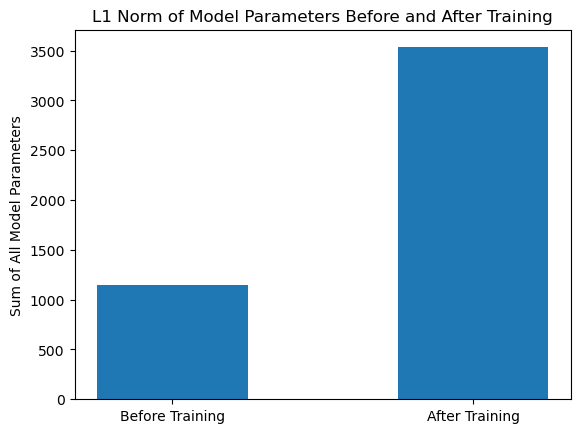

In [81]:
# create model
model = utils.create_model(hidden_layer_size=64)

nepochs = 50

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

l1_norm_pre_training = utils.calculate_l1_norm(model)

# train model
for epoch in range(nepochs):
    utils.train(model, features_train, labels_train, optimizer=optimizer, )

l1_norm_post_training = utils.calculate_l1_norm(model)

# plot sum of all model parameters
plt.bar(['Before Training', 'After Training'], [l1_norm_pre_training.detach(), l1_norm_post_training.detach()], width=0.5)
plt.ylabel("Sum of All Model Parameters")
plt.title('L1 Norm of Model Parameters Before and After Training');

**Exercise**: Calculate the accuracy of the model trained above on the `features_test` and `labels_test` data. 

**Hint**: Use a utility function that can be found in the code reference table.

**Example**: Train the model created below with an L1 penalty. Run the cell after the training to calculate the accuracy of the trained model and to plot the sum of the model parameters before and after training. Are the model parameters smaller or bigger than before training this time? How high is the accuracy?

In [14]:
# create model
model = utils.create_model(hidden_layer_size=64)

nepochs = 50

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

l1_norm_pre_training = utils.calculate_l1_norm(model)

In [15]:
lam1 = 1
for epoch in range(nepochs):
    l1_norm = utils.calculate_l1_norm(model)

    l1_penalty = lam1*l1_norm

    utils.train(model, features_train, labels_train, optimizer=optimizer, penalty = l1_penalty)

Accuracy: 39.74359130859375


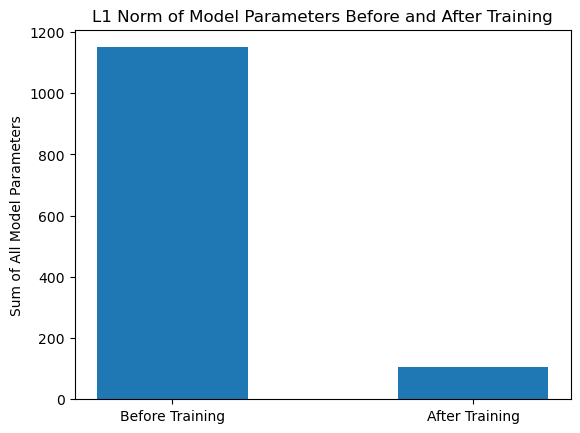

In [16]:
utils.calculate_accuracy(model, features_test, labels_test)

l1_norm_post_training = utils.calculate_l1_norm(model)

# plot sum of all model parameters
plt.bar(['Before Training', 'After Training'], [l1_norm_pre_training.detach(), l1_norm_post_training.detach()], width=0.5)
plt.ylabel("Sum of All Model Parameters")
plt.title('L1 Norm of Model Parameters Before and After Training');

The penalty might have been too large in the example above.

**Exercise**: Set `lam1 = 0.01` and train the model created below with an L1 penalty. The `lam1` is used to control how big the penalty on large parameters should be. Run the cell after the training to calculate the accuracy of the trained model and to plot the sum of the model parameters before and after training. Are the model parameters smaller or bigger than before training this time? How high is the accuracy?

**Hint**: The penalty is added through setting a parameter in `utils.train`.

In [17]:
# create model
model = utils.create_model(hidden_layer_size=64)

nepochs = 50

optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.01)

l1_norm_pre_training = utils.calculate_l1_norm(model)

Accuracy: 42.30769348144531


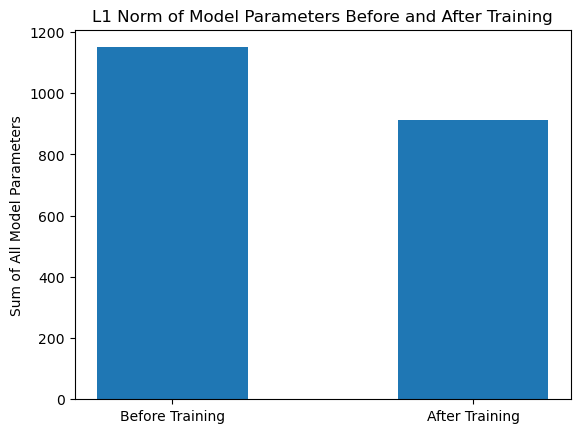

In [19]:
utils.calculate_accuracy(model, features_test, labels_test)

l1_norm_post_training = utils.calculate_l1_norm(model)

# plot sum of all model parameters
plt.bar(['Before Training', 'After Training'], [l1_norm_pre_training.detach(), l1_norm_post_training.detach()], width=0.5)
plt.ylabel("Sum of All Model Parameters")
plt.title('L1 Norm of Model Parameters Before and After Training');

**Exercise**: Set `lam1 = 0.5` and train the model created below with an L1 penalty. Run the cell after the training to calculate the accuracy of the trained model and to plot the sum of the model parameters before and after training. Are the model parameters smaller or bigger than before training this time? How high is the accuracy?

In [20]:
# create model
model = utils.create_model(hidden_layer_size=64)

nepochs = 50

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

l1_norm_pre_training = utils.calculate_l1_norm(model)

Accuracy: 44.871795654296875


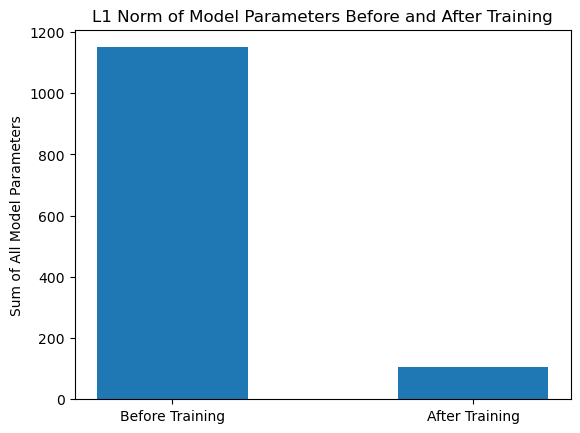

In [22]:
utils.calculate_accuracy(model, features_test, labels_test)

l1_norm_post_training = utils.calculate_l1_norm(model)

# plot sum of all model parameters
plt.bar(['Before Training', 'After Training'], [l1_norm_pre_training.detach(), l1_norm_post_training.detach()], width=0.5)
plt.ylabel("Sum of All Model Parameters")
plt.title('L1 Norm of Model Parameters Before and After Training');

## Section 2: Ridge regularization to Improve Network Performance

Ridge regularization (also called L2 regularization or weight decay) is similar to Lasso regularization. The difference is that the penalty added to the loss function is the **square root of the sum of the squared values** of the model's parameters, instead of the sum of **absolute values**. Unlike L1 regularization, L2 tends to shrink all parameters towards zero without pushing them exactly to zero. This makes L2 regularization particularly effective when features are correlated with each other (collinearity), as it distributes the model's learning across many features rather than relying heavily on just a few.

The equation for the L2 norm of the model parameters:
 
 $$L2 = \sqrt{\sum_{i} p_i^2}$$

The strength of the penalty in Ridge regularization is also controlled by a pre factor called $\lambda$. Thus, the equation for the loss with Ridge regularization becomes:

$$\mathcal{L}_{regularized} = \mathcal{L} + \lambda \sqrt{\sum_{i} p_i^2}$$

where $\mathcal{L}$ is the loss. <br><br>

| Code | Description |
| :-- | :-- |
| `torch.sum(data)` | Sum of a tensor `data`. |
| `torch.sqrt(data)` | Square root of a tensor `data`. |
| `l2_norm = 0.0`<br>`for params in model.parameters():`<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`l2_norm += torch.sum(params**2)`<br>`l2_norm = torch.sqrt(l2_norm)` | Calculate L2 norm for the parameters in `model`. |
| `utils.calculate_l2_norm(model)` | Utility function to calculate L2 norm for `model`. |
| `utils.calculate_accuracy(model, features_test, labels_test)` | Utility function to calculate accuracy on test data. |
| `l2_penalty = lam2 * l2_norm` | Scale L2 norm by a factor to create penalty term. |
| `utils.train(model, features_train, labels_train)` | Utility function to train model. |
| `utils.train(model, features_train, labels_train, penalty=l2_penalty)` | Utility function to train model with L2 regularization penalty. |

#### **Exercises**

**Example**: For the model created below, calculate the L2 norm of all model parameters.

In [23]:
# create model
model = utils.create_model(hidden_layer_size=64)

In [24]:
# calculate L2 norm of all model parameters
params_sum = 0.0
for name, params in model.named_parameters():
    print(f"Number of {name.split('.')[-1]} parameters in layer: {params.numel()}")
    params_sum += torch.sum(params**2)

l2_norm = torch.sqrt(params_sum)

print(f"L2 Norm of All Model Parameters Pre-Training: {l2_norm.detach().item():.4f}")

Number of weight parameters in layer: 81152
Number of bias parameters in layer: 64
Number of weight parameters in layer: 192
Number of bias parameters in layer: 3
L2 Norm of All Model Parameters Pre-Training: 4.7219


**Exercise**: Create a model with `hidden_layer_size=6` and calculate the L2 norm of all model parameters (try to do it without using the utility function). Is the L2 norm of this model's parameters smaller or bigger than the model in the example above? Why?

**Exercise**: Calculate the L2 norm for the parameters of the model created below.

In [26]:
# create model
model = utils.create_model(hidden_layer_size=128)

**Example**: Train the model created below with `lam2 = 0.0`, i.e. without an L2 penalty. Run the cell after the training to calculate the accuracy of the trained model and to plot the L2 norm of the model parameters before and after training. How high is the accuracy?

In [28]:
# create model
model = utils.create_model(hidden_layer_size=64)

nepochs = 50

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

l2_norm_pre_training = utils.calculate_l2_norm(model)

In [29]:
lam2 = 0.0
for epoch in range(nepochs):
    l2_norm = utils.calculate_l2_norm(model)

    l2_penalty = lam2*l2_norm

    utils.train(model, features_train, labels_train, optimizer=optimizer, penalty = l2_penalty)

Accuracy: 38.46154022216797


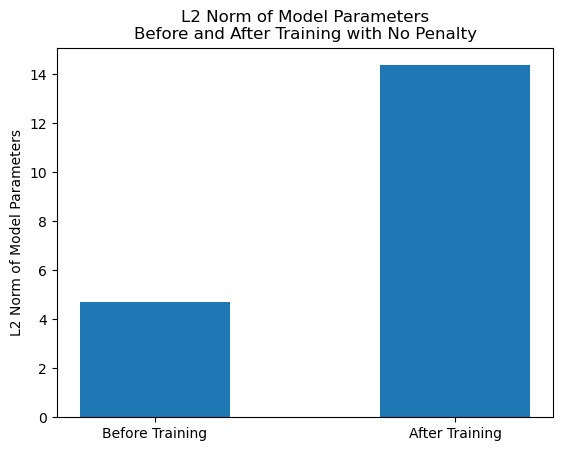

In [30]:
utils.calculate_accuracy(model, features_test, labels_test)

l2_norm_post_training = utils.calculate_l2_norm(model)

# plot L2 norm of all model parameters
plt.bar(['Before Training', 'After Training'], [l2_norm_pre_training.detach(), l2_norm_post_training.detach()], width=0.5)
plt.ylabel("L2 Norm of Model Parameters")
plt.title('L2 Norm of Model Parameters\nBefore and After Training with No Penalty');

**Exercise**: Set `lam2 = 0.5` and train the model created below with an L2 penalty. Run the cell after the training to calculate the accuracy of the trained model and to plot the L2 norm of the model parameters before and after training. How high is the accuracy?

In [ ]:
# create model
model = utils.create_model(hidden_layer_size=64)

nepochs = 50

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

l2_norm_pre_training = utils.calculate_l2_norm(model)

Accuracy: 41.02564239501953


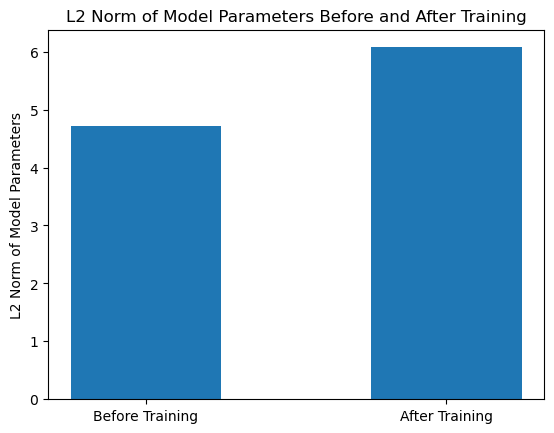

In [63]:
utils.calculate_accuracy(model, features_test, labels_test)

l2_norm_post_training = utils.calculate_l2_norm(model)

# plot L2 norm of all model parameters
plt.bar(['Before Training', 'After Training'], [l2_norm_pre_training.detach(), l2_norm_post_training.detach()], width=0.5)
plt.ylabel("L2 Norm of Model Parameters")
plt.title('L2 Norm of Model Parameters Before and After Training');

**Demo**: The accuracy was slightly higher with L2 regularization than with L1 regularization (at least for the values of the `lam1` and `lam2` that we tested here). You might be wondering how they differ in their effect on the model parameters during training and when to use one or the other.

- L1 regularization tends to drive some parameters all the way to 0. It's a good idea when you have features that are likely to be unimporant.

- L2 regularization tends to make all parameters smaller, and especially the largest ones, rather than driving some parameters to 0. It's a good idea to use when there's collinearity (correlation) between some of the features.

Note that it's also possible to use a combination of L1 and L2 regularization.

The figure below shows the distribution of parameters after training with no regularization and with L1 or L2 regularization. Does it confirm the claims above about what the L1 and L2 regularization do to the parameters?

(-0.25, 0.15)

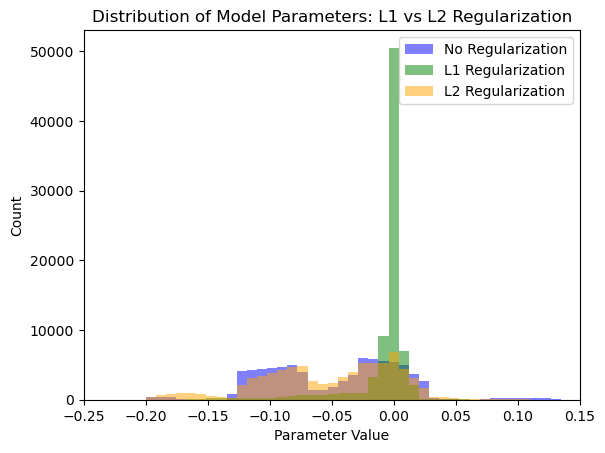

In [64]:
# train model with no regularization

# create model
model = utils.create_model(hidden_layer_size=64)

nepochs = 50

optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.01)

l2_norm_pre_training = utils.calculate_l2_norm(model)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)

for epoch in range(nepochs):
    utils.train(model, features_train, labels_train, optimizer=optimizer)

# train model with L1 regularization

model_l1 = utils.create_model(hidden_layer_size=64)

optimizer_l1 = torch.optim.RMSprop(model_l1.parameters(), lr=0.01)

lam1 = 0.01
for epoch in range(nepochs):
    l1_norm = utils.calculate_l1_norm(model_l1)
    l1_penalty = lam1 * l1_norm
    utils.train(model_l1, features_train, labels_train, optimizer=optimizer_l1, penalty=l1_penalty)

# train model with L2 regularization
model_l2 = utils.create_model(hidden_layer_size=64)
optimizer_l2 = torch.optim.RMSprop(model_l2.parameters(), lr=0.01)

lam2 = 0.01
for epoch in range(nepochs):
    l2_norm = utils.calculate_l2_norm(model_l2)
    l2_penalty = lam2 * l2_norm
    utils.train(model_l2, features_train, labels_train, optimizer=optimizer_l2, penalty=l2_penalty)

# get all parameters from model trained with no, l1, and l2 regularization
params_no_reg = torch.cat([p.flatten() for p in model.parameters()]).detach().numpy()
params_l1_reg = torch.cat([p.flatten() for p in model_l1.parameters()]).detach().numpy()
params_l2_reg = torch.cat([p.flatten() for p in model_l2.parameters()]).detach().numpy()

# plot overlapping histograms
bins = np.linspace(-0.2, 0.2, 50)
plt.hist(params_no_reg, bins=bins, alpha=0.5, label='No Regularization', color='blue')
plt.hist(params_l1_reg, bins=bins, alpha=0.5, label='L1 Regularization', color='green')
plt.hist(params_l2_reg, bins=bins, alpha=0.5, label='L2 Regularization', color='orange')
plt.xlabel('Parameter Value')
plt.ylabel('Count')
plt.title('Distribution of Model Parameters: L1 vs L2 Regularization')
plt.legend()
plt.xlim([-0.25, 0.15])

## Section 3: Regularize the Model with Dropout to Improve Network Performance

Dropout is a regularization technique that randomly "drops out" (sets to zero) a fraction of neurons during training. This prevents the network from relying too heavily on any single or just a few neurons which often happens when the model is just memorizing the training data rather than learning robust, generalizable patterns.

| Code | Description |
|---|---|
| `nn.Dropout(p=0.5)` | Dropout layer that randomly sets 50% of inputs to zero during training. |
| `model.train()` | Set model to training mode (dropout is active). |
| `model.eval()` | Set model to evaluation mode (dropout is disabled). |
| `utils.calculate_accuracy(model, features_test, labels_test)` | Utility function to calculate accuracy on test data. |
| `nn.Sequential(`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Linear(1,10),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.ReLU(),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Dropout(0.5)`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Linear(10,1)`<br>`)` | Creates a container where layers and activation functions are stacked in a sequential order. `nn.Dropout` will act on the output of the previous layer. |

#### **Exercises**

Run the cell below to define the model used for this section.

**Example**: Apply dropout with `p=0.5` to the `x` created below, which is a tensor of `1`'s. Assign the result to a variable named `x_dropped`.

In [65]:
# create a tensor of ones
x = torch.ones(10)

In [66]:
# apply dropout
x_dropped = nn.Dropout(p=0.5)(x)

Run the cell below after applying dropout to `x`.

In [67]:
print(f"Original tensor: {x}")
print(f"Tensor after dropout: {x_dropped}")

Original tensor: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Tensor after dropout: tensor([0., 0., 2., 2., 0., 0., 0., 2., 0., 2.])


**Exercise**: Apply dropout with `p=0.2` to the `x` created below. Assign the result to a variable named `x_dropped`.

In [68]:
# create a tensor of ones
x = torch.ones(10)

Run the cell below after applying dropout to `x`.

In [70]:
print(f"Original tensor: {x}")
print(f"Tensor after dropout: {x_dropped}")

Original tensor: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Tensor after dropout: tensor([1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500,
        1.2500])


**Exercise**: Apply dropout with `p=0.5` to the `x` created below, which is a tensor of `10`'s. Assign the result to a variable named `x_dropped`.

In [71]:
# create a tensor of ones
x = torch.zeros(10) + 10

Run the cell below after applying dropout to `x`.

In [73]:
print(f"Original tensor: {x}")
print(f"Tensor after dropout: {x_dropped}")

Original tensor: tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])
Tensor after dropout: tensor([20., 20.,  0., 20., 20., 20.,  0., 20., 20.,  0.])


**Demo**: You may have noticed that the elements that aren't zeroed become larger. That's to ensure that the expected value stays the same. If you apply dropout many times and calculate the average of the tensors with dropped values you will see that the average element value is close to the original tensor values. This is done in the cell below.

In [74]:
torch.manual_seed(SEED)
# create a tensor of ones
x = torch.ones(10)

N = 1000
x_dropped = torch.zeros_like(x)
for i in range(N):
    # apply dropout
    x_dropped += nn.Dropout(p=0.5)(x)

print(f"Original tensor: {x}")
print(f"Average tensor values after dropout: {(x_dropped/N)}")

Original tensor: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Average tensor values after dropout: tensor([1.0240, 0.9960, 0.9580, 0.9720, 1.0260, 1.0100, 0.9640, 0.9920, 1.0160,
        1.0680])


**Example**: Create and train a model without dropout and check the accuracy. This will serve as our baseline.

In [80]:
# create model
model = utils.create_model(hidden_layer_size=64)

nepochs = 50

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

# train the model
for epoch in range(nepochs):
    utils.train(model, features_train, labels_train, optimizer=optimizer)

# set to eval mode before testing (disables dropout)
model.eval()

# test model
print("Model without dropout (p=0.0):")
utils.calculate_accuracy(model, features_test, labels_test)

Model without dropout (p=0.0):
Accuracy: 33.333335876464844


33.333335876464844

**Exercise**: Create a model with `dropout_rate=0.5`. Then, run the cell below to train it and and compute the accuracy. `model.eval()` is used in the provided code to set the model to evaluation mode before calculating accuracy, so that dropout is disabled during testing.

**Exercise**: Create and train a model with `dropout_rate=0.1` and compare the accuracy to the models above. Is the accuracy higher or lower?

## Section 4: Regularization through Early Stopping

Early stopping is a regularization technique that monitors the model's performance on a validation set during training and stops when performance stops improving. This prevents the model from overfitting to the training data.

| Code | Description |
|---|---|
| `patience = 20` | Number of epochs to wait for improvement before stopping. |
| `wait = 0` | Counter for epochs without improvement. |
| `if val_acc > best_acc:` | Check if current validation accuracy is better than the best so far. |
| `break` | Exit the training loop early. |
| `if val_acc > best_acc:`<br>&nbsp;&nbsp;&nbsp;&nbsp;`best_acc = val_acc`<br>&nbsp;&nbsp;&nbsp;&nbsp;`wait = 0`<br>`else:`<br>&nbsp;&nbsp;&nbsp;&nbsp;`wait += 1`<br><br>`if wait > patience:`<br>&nbsp;&nbsp;&nbsp;&nbsp;`break` | Early stopping logic. Check if the current accuracy on the validation dataset is higher than the previous best accuracy.<br>If it is, update the best accuracy and continue. If it isn't, update counter of how many epochs have passed <br> since the accuracy improved. If the number of epochs without improvement is higher than `patience`,<br>stop training. |

#### **Exercises**

Run the two cells below to define the model used for this section and to split the data into a train, validation, and test dataset. The validation dataset is used to determine when to stop the training.

In [50]:
# create model
model = utils.create_model(hidden_layer_size=64)

In [51]:
SEED = 2026
generator = torch.Generator().manual_seed(SEED)

train_fraction = 0.7
val_fraction = 0.15
test_fraction = 1-train_fraction-val_fraction

features_train, features_val, features_test = random_split(features, lengths=[train_fraction, val_fraction, test_fraction], generator=generator)
labels_train, labels_val, labels_test = random_split(labels, lengths=[train_fraction, val_fraction, test_fraction], generator=generator)

features_train, features_val, features_test = features_train.dataset[features_train.indices].float(), features_val.dataset[features_val.indices].float(), features_test.dataset[features_test.indices].float()
labels_train, labels_val, labels_test = labels_train.dataset[labels_train.indices], labels_val.dataset[labels_val.indices], labels_test.dataset[labels_test.indices]

**Demo**: First, let's see what happens when we train for many epochs without early stopping. We'll track both training and validation accuracy over time to observe overfitting.

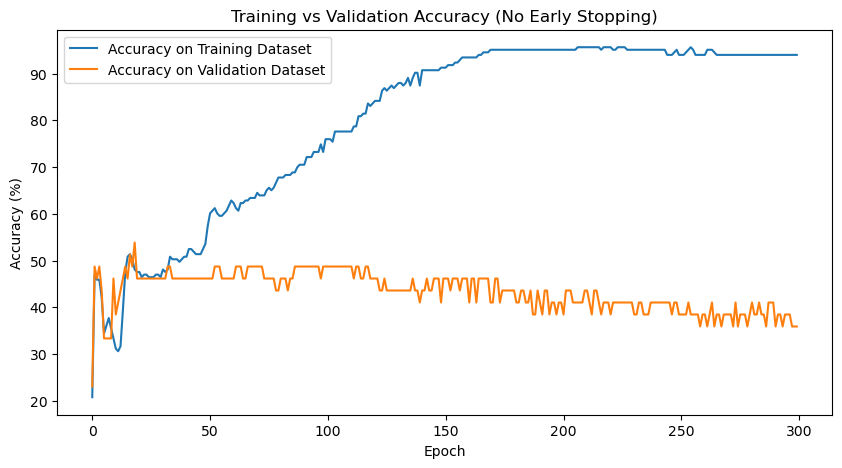

In [52]:
nepochs = 300

model = utils.create_model(hidden_layer_size=32, SEED = 2026)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_accuracy_list = []
val_accuracy_list = []

for epoch in range(nepochs):
    # train the model
    utils.train(model, features_train, labels_train, optimizer=optimizer)
    
    # calculate training and validation accuracy
    train_acc = utils.calculate_accuracy(model, features_train, labels_train, verbose = False)
    val_acc = utils.calculate_accuracy(model, features_val, labels_val, verbose = False)
    
    train_accuracy_list.append(train_acc)
    val_accuracy_list.append(val_acc)

# plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_list, label='Accuracy on Training Dataset')
plt.plot(val_accuracy_list, label='Accuracy on Validation Dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy (No Early Stopping)')
plt.legend();

Notice how training accuracy keeps improving but validation accuracy plateaus or even decreases after a certain point. This is a sign of overfitting: the model may be memorizing the training data instead of learning generalizable patterns.

**Example**: Implement early stopping with `patience=20`. Training will stop if validation accuracy doesn't improve for 20 consecutive epochs.

Early stopped on epoch: 39
Best validation accuracy: 46.15% at epoch 18


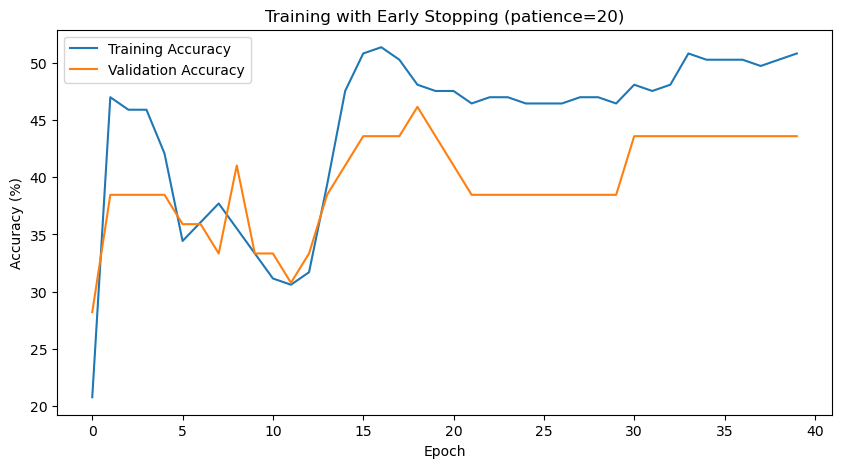

In [53]:
nepochs = 300

model = utils.create_model(hidden_layer_size=32,)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_acc = 0.0
best_epoch = 0
patience = 20
wait = 0

train_accuracy_list = []
val_accuracy_list = []

for epoch in range(nepochs):
    # train the model
    utils.train(model, features_train, labels_train, optimizer=optimizer)
    
    # calculate training and validation accuracy
    train_acc = utils.calculate_accuracy(model, features_train, labels_train, verbose=False)
    val_acc = utils.calculate_accuracy(model, features_test, labels_test, verbose=False)
    
    train_accuracy_list.append(train_acc)
    val_accuracy_list.append(val_acc)
    
    # early stopping logic
    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch
        wait = 0
    else:
        wait += 1
    
    if wait > patience:
        print(f'Early stopped on epoch: {epoch}')
        break

# plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_list, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Training with Early Stopping (patience={patience})')
plt.legend()

print(f"Best validation accuracy: {best_acc:.2f}% at epoch {best_epoch}")

**Exercise**: Try early stopping with `patience=3`. Does training stop earlier? What is the best validation accuracy achieved?

Best validation accuracy: 46.15% at epoch 18


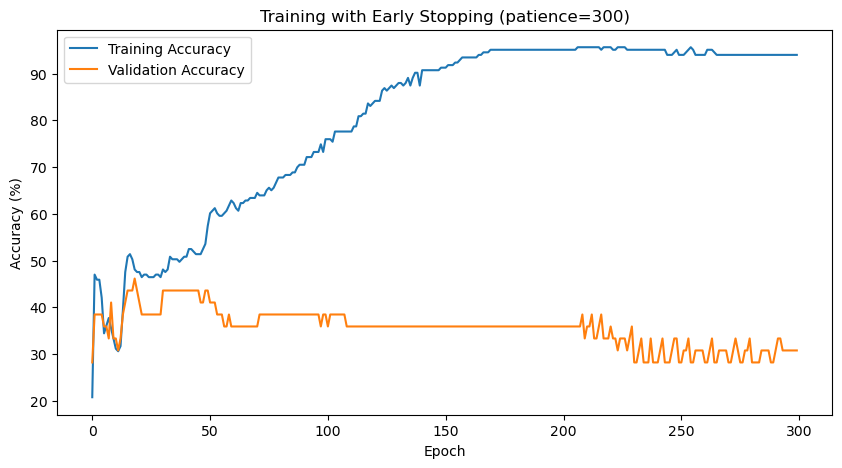

In [54]:
nepochs = 300

model = utils.create_model(hidden_layer_size=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_acc = 0.0
best_epoch = 0
patience = 300  # UPDATE ME try a smaller patience
wait = 0

train_accuracy_list = []
val_accuracy_list = []

for epoch in range(nepochs):
    # train the model
    utils.train(model, features_train, labels_train, optimizer=optimizer)
    
    # calculate training and validation accuracy
    train_acc = utils.calculate_accuracy(model, features_train, labels_train, verbose=False)
    val_acc = utils.calculate_accuracy(model, features_test, labels_test, verbose=False)
    
    train_accuracy_list.append(train_acc)
    val_accuracy_list.append(val_acc)
    
    # early stopping logic
    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch
        wait = 0
    else:
        wait += 1
    
    if wait > patience:
        print(f'Early stopped on epoch: {epoch}')
        break

# plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_list, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Training with Early Stopping (patience={patience})')
plt.legend()

print(f"Best validation accuracy: {best_acc:.2f}% at epoch {best_epoch}")

**Exercise**: Try early stopping with `patience=40`. Does training stop later? What is the best validation accuracy achieved? Is it higher or lower than with smaller patience values?

Best validation accuracy: 53.85% at epoch 18


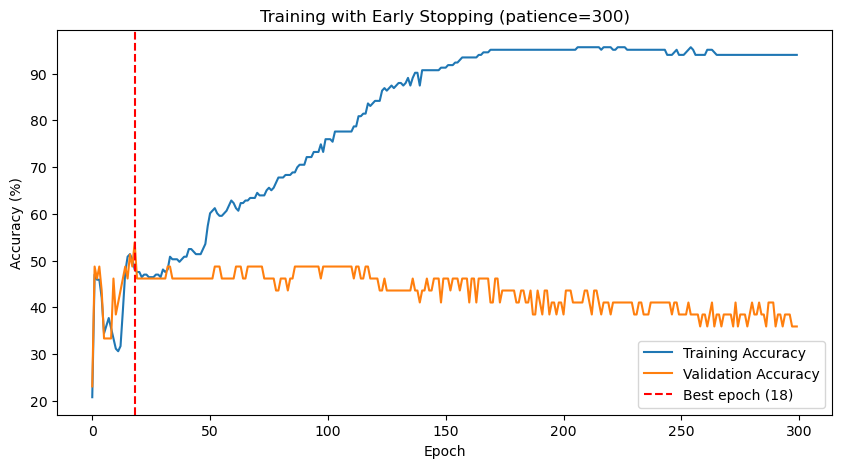

In [56]:
nepochs = 300

model = utils.create_model(hidden_layer_size=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_acc = 0.0
best_epoch = 0
patience = 300  # UPDATE ME
wait = 0

train_accuracy_list = []
val_accuracy_list = []

for epoch in range(nepochs):
    # train the model
    utils.train(model, features_train, labels_train, optimizer=optimizer)
    
    # calculate training and validation accuracy
    train_acc = utils.calculate_accuracy(model, features_train, labels_train, verbose=False)
    val_acc = utils.calculate_accuracy(model, features_val, labels_val, verbose=False)
    
    train_accuracy_list.append(train_acc)
    val_accuracy_list.append(val_acc)
    
    # early stopping logic
    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch
        wait = 0
    else:
        wait += 1
    
    if wait > patience:
        print(f'Early stopped on epoch: {epoch}')
        break

# plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_list, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best epoch ({best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Training with Early Stopping (patience={patience})')
plt.legend()

print(f"Best validation accuracy: {best_acc:.2f}% at epoch {best_epoch}")